In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [29]:
filestream = io.StringIO(
        requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv').content.decode('utf-8')
    )

In [30]:
dataset = pd.read_csv(
    filestream,    
    usecols=[
        'dateRep', 
        'cases', 
        'deaths',
        'countriesAndTerritories',
        'popData2018',
    ],
    parse_dates=['dateRep'],
    infer_datetime_format=True,
)

In [31]:
df = pd.read_csv("Datasets/features_format_final.csv", parse_dates=["date"])

In [32]:
df.head()

,date,country,confirmed,recovered,deaths,country_code,S1_School closing,S1_IsGeneral,S2_Workplace closing,S2_IsGeneral,...,StringencyIndex,StringencyIndexForDisplay,region,pct_positive,test_by_million,GDP per capita (current US$),Current health expenditure per capita (current US$),Population ages 65 and above (% of total population),Population density,Urban population (% of total population)
0,2020-01-22,Afghanistan,0.0,0.0,0.0,AFG,0.0,1.0,0.0,NaN,...,0.0,0.0,South Asia,5.6775,445.5,520.896603,67.12265,2.584927,56.93776,25.495
1,2020-01-23,Afghanistan,0.0,0.0,0.0,AFG,0.0,1.0,0.0,NaN,...,0.0,0.0,South Asia,5.6775,445.5,520.896603,67.12265,2.584927,56.93776,25.495
2,2020-01-24,Afghanistan,0.0,0.0,0.0,AFG,0.0,1.0,0.0,NaN,...,0.0,0.0,South Asia,5.6775,445.5,520.896603,67.12265,2.584927,56.93776,25.495
3,2020-01-25,Afghanistan,0.0,0.0,0.0,AFG,0.0,1.0,0.0,NaN,...,0.0,0.0,South Asia,5.6775,445.5,520.896603,67.12265,2.584927,56.93776,25.495
4,2020-01-26,Afghanistan,0.0,0.0,0.0,AFG,0.0,1.0,0.0,NaN,...,0.0,0.0,South Asia,5.6775,445.5,520.896603,67.12265,2.584927,56.93776,25.495


In [33]:
dataset.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018
0,2020-04-18,51,1,Afghanistan,37172386.0
1,2020-04-17,10,4,Afghanistan,37172386.0
2,2020-04-16,70,2,Afghanistan,37172386.0
3,2020-04-15,49,2,Afghanistan,37172386.0
4,2020-04-14,58,3,Afghanistan,37172386.0


In [34]:
df = df.sort_values("date")

In [35]:
dataset = dataset.sort_values("dateRep")

In [36]:
forcast_days = 7 
split_date = dataset["dateRep"].max() - np.timedelta64(forcast_days, 'D')

In [37]:
forcast_days = 7 
split_date_nash = df["date"].max() - np.timedelta64(forcast_days, 'D')

In [38]:
train_nash = df.loc[df['date'] < split_date_nash]
test_nash = df.loc[df['date'] >= split_date_nash]

In [39]:
train = dataset.loc[dataset['dateRep'] < split_date]
test = dataset.loc[dataset['dateRep'] >= split_date]

In [40]:
train.isna().sum(axis=0)

dateRep                     0
cases                       0
deaths                      0
countriesAndTerritories     0
popData2018                51
dtype: int64

In [41]:
train_nash.isna().sum(axis=0)

date                                                        0
country                                                     0
confirmed                                                   0
recovered                                                   0
deaths                                                      0
country_code                                                0
S1_School closing                                        4302
S1_IsGeneral                                            10066
S2_Workplace closing                                     4461
S2_IsGeneral                                            10917
S3_Cancel public events                                  4364
S3_IsGeneral                                            10044
S4_Close public transport                                4482
S4_IsGeneral                                            11807
S5_Public information campaigns                          4457
S5_IsGeneral                                             8112
S6_Restr

In [42]:
def MSLE_loss(one, two):
    loss = np.mean((np.log1p(one) - np.log1p(two))**2)  # MSLE loss
    return loss

def run_arima(train, test, order):
    model = ARIMA(train, order=order)
    model = model.fit(disp=0)
    predictions = model.forecast(steps=len(test))[0]
    loss = MSLE_loss(test, predictions)  # MSLE loss
    return loss

def evaluate_arima_params(train, test, p_list, d_list, q_list, verbose=0):
    best_loss, best_params = float("inf"), (0,0,0)
    for params in itertools.product(p_list, d_list, q_list):
        try:
            loss = run_arima(train, test, params)
            if loss < best_loss:
                best_loss, best_params = loss, params
        except:
            continue 
    
    if verbose > 0:
        print(f'Best ARIMA params {best_params} with loss={best_loss}')
    return best_loss, best_params

### Fitting ARIMA model to the one country time series series NAŠE!!

In [87]:
from statsmodels.tsa.arima_model import ARIMA
country = "Uganda"

In [88]:
timeseries = train_nash[train_nash["country"] == country]["confirmed"].tolist()

In [89]:
test_one_country = test_nash[test_nash["country"] == country]

In [90]:
run_arima(timeseries, test_one_country["confirmed"], (1,0,1))

0.23320339962991585

In [91]:
loss, params = evaluate_arima_params(timeseries, test_one_country["confirmed"], [0,1,2,4], [0,1,2,4], [0,1,2,4], verbose=1)

Best ARIMA params (4, 0, 0) with loss=0.10323194018272533


In [92]:
model = ARIMA(timeseries, order=params)
model = model.fit(disp=False)

In [93]:
preds = model.forecast(steps=len(test_one_country))[0]

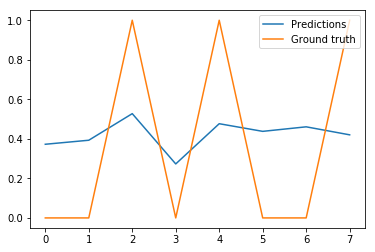

In [94]:
plt.plot(preds, label="Predictions")
plt.plot(test_one_country["confirmed"].tolist(), label="Ground truth")
plt.legend()

In [95]:
MSLE_loss(test_one_country["confirmed"].tolist(), preds)

0.10323194018272533

In [24]:
country_list = df["country"].unique()

In [25]:
loss, params = evaluate_arima_params(timeseries, test_one_country["confirmed"], [0,1,2,4], [0,1,2,4], [0,1,2,4])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: Hessian

In [ ]:
%%capture
predictions = pd.DataFrame()
for country in country_list:
    timeseries = train_nash[train_nash["country"] == country]["confirmed"].tolist()
    test_one_country = test_nash[test_nash["country"] == country]
    if len(test_one_country) == 0:
        print(f"There is no test data for {country}")
        continue
    loss, params = evaluate_arima_params(timeseries, test_one_country["confirmed"], [0,1,2,4], [0,1,2,4], [0,1,2,4])
    if len(timeseries) == 0:
        preds = 0 * len(test_one_country)
    elif len(timeseries) < len(test_one_country):
        preds = timeseries[-1] * len(test_one_country)
    else:
        model = ARIMA(timeseries, order=params)
        model = model.fit(disp=False)
        preds = model.forecast(steps=len(test_one_country))[0]
    test_one_country["predictions"] = preds
    predictions = predictions.append(test_one_country)

In [ ]:
MSLE_loss(predictions["confirmed"], predictions["predictions"])

### Fitting ARIMA model to the one country time series siries

In [52]:
from statsmodels.tsa.arima_model import ARIMA

In [53]:
country = "Italy"

In [54]:
timeseries = train[train["countriesAndTerritories"] == country]["cases"].tolist()

In [55]:
test_one_country = test[test["countriesAndTerritories"] == country]

In [57]:
run_arima(timeseries, test_one_country["cases"], (1,0,1))

0.042310226659878956

In [58]:
loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2], verbose=1)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA params (2, 0, 1) with loss=0.029138116424205735


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [59]:
model = ARIMA(timeseries, order=params)

In [60]:
model = model.fit(disp=False)

In [61]:
preds = model.forecast(steps=len(test_one_country))[0]

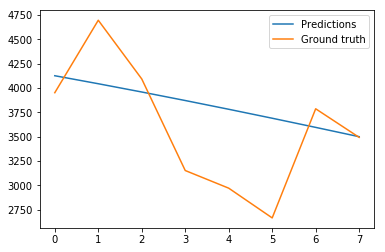

In [62]:
plt.plot(preds, label="Predictions")
plt.plot(test_one_country["cases"].tolist(), label="Ground truth")
plt.legend()

### Run this on all countries

In [20]:
country_list = dataset["countriesAndTerritories"].unique()

In [21]:
loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Next cell will take few minutes:

In [22]:
%%capture
predictions = pd.DataFrame()
for country in country_list:
    timeseries = train[train["countriesAndTerritories"] == country]["cases"].tolist()
    test_one_country = test[test["countriesAndTerritories"] == country]
    if len(test_one_country) == 0:
        print(f"There is no test data for {country}")
        continue
    loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2])
    if len(timeseries) == 0:
        preds = 0 * len(test_one_country)
    elif len(timeseries) < len(test_one_country):
        preds = timeseries[-1] * len(test_one_country)
    else:
        model = ARIMA(timeseries, order=params)
        model = model.fit(disp=False)
        preds = model.forecast(steps=len(test_one_country))[0]
    test_one_country["predictions"] = preds
    predictions = predictions.append(test_one_country)

### Score on cases:

In [23]:
MSLE_loss(predictions["cases"], predictions["predictions"])

0.6496807493812081